## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/codes.txt'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/valid.txt'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/images/Seq05VD_f03780.png'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/images/Seq05VD_f02430.png'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/images/0016E5_08081.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/Seq05VD_f03330_P.png'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/0016E5_08149_P.png'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/camvid/labels/0001TP_010260_P.png')]

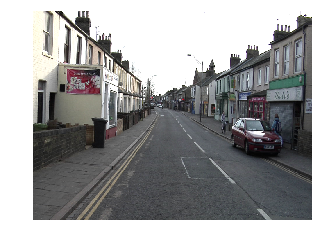

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

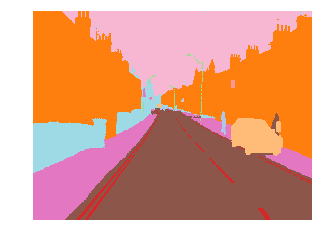

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [12]:
size = src_size//2
bs=8

In [13]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

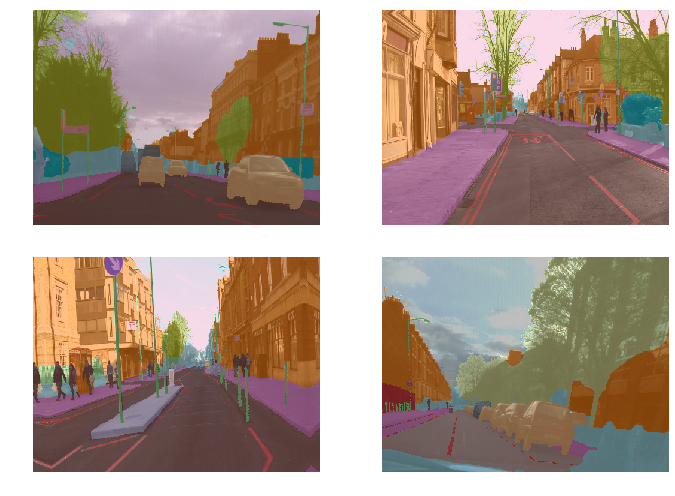

In [15]:
data.show_batch(2, figsize=(10,7))

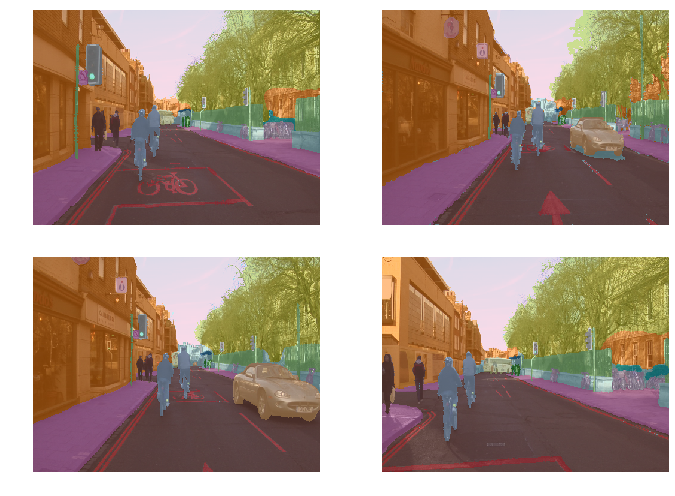

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


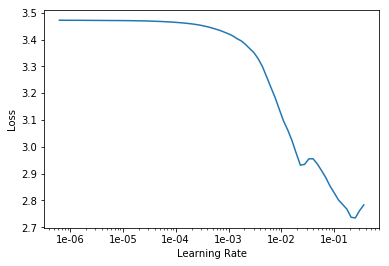

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-2

In [ ]:
learn.fit_one_cycle(10, slice(lr))

Total time: 02:33
epoch  train_loss  valid_loss  acc_camvid
1      1.636467    0.881490    0.828823    (00:16)
2      0.944971    0.694528    0.815188    (00:15)
3      0.733927    0.764055    0.829361    (00:15)
4      0.662004    0.632483    0.851728    (00:15)
5      0.607342    0.449596    0.868218    (00:15)
6      0.550737    0.444870    0.879795    (00:15)
7      0.506105    0.405386    0.874481    (00:15)
8      0.466920    0.342197    0.908723    (00:15)
9      0.438360    0.360003    0.890411    (00:15)
10     0.416060    0.346647    0.897131    (00:15)



In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

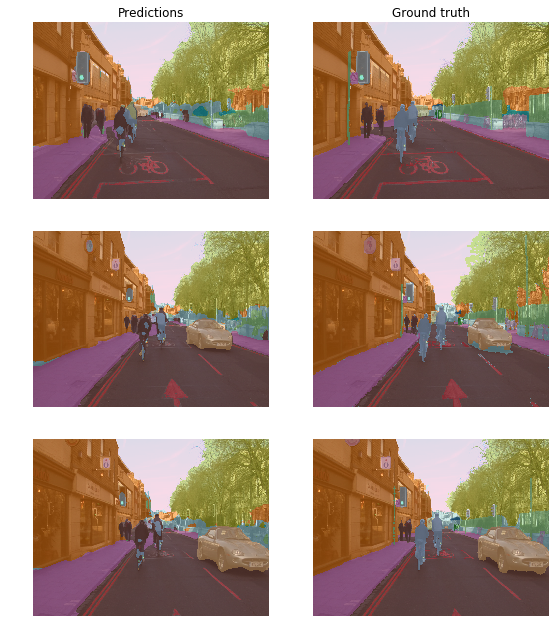

In [ ]:
learn.show_results()

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


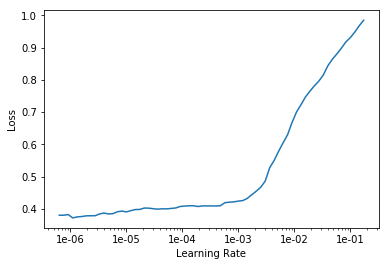

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5,lr/5)

In [ ]:
learn.fit_one_cycle(12, lrs)

Total time: 03:27
epoch  train_loss  valid_loss  acc_camvid
1      0.404831    0.345471    0.896114    (00:17)
2      0.407816    0.333158    0.902820    (00:17)
3      0.411553    0.383799    0.885798    (00:17)
4      0.414742    0.327556    0.904671    (00:17)
5      0.396832    0.336016    0.900984    (00:17)
6      0.383323    0.308091    0.912436    (00:17)
7      0.370369    0.312346    0.912357    (00:17)
8      0.359498    0.308674    0.914836    (00:17)
9      0.338336    0.298403    0.913483    (00:17)
10     0.327419    0.288768    0.917118    (00:17)
11     0.320903    0.287090    0.918583    (00:17)
12     0.319342    0.282482    0.920697    (00:17)



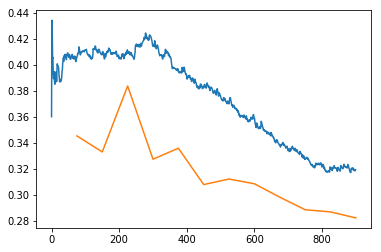

In [ ]:
learn.recorder.plot_losses()

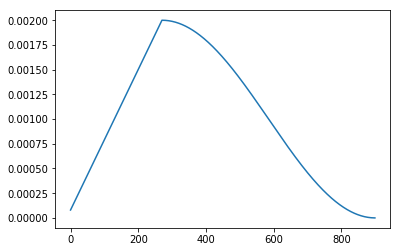

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=4

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


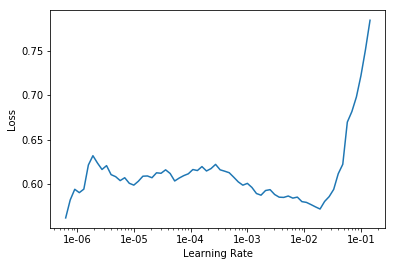

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

Total time: 08:35
epoch  train_loss  valid_loss  acc_camvid
1      0.478651    0.353326    0.899819    (00:56)
2      0.413465    0.327796    0.905830    (00:51)
3      0.392178    0.329053    0.909291    (00:50)
4      0.379366    0.318349    0.907988    (00:51)
5      0.370995    0.326135    0.909895    (00:50)
6      0.332380    0.541983    0.910795    (00:51)
7      0.323422    0.294250    0.915216    (00:50)
8      0.328400    0.297770    0.918176    (00:51)
9      0.305972    0.295046    0.915488    (00:51)
10     0.304560    0.286477    0.916800    (00:51)



In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr)

In [ ]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

epoch,train_loss,valid_loss,acc_camvid
1,0.321421,0.347671,0.917316
2,0.315810,0.281045,0.921787
3,0.323424,0.326843,0.908457
4,0.322396,0.285744,0.923071
5,0.296722,0.298660,0.913992
6,0.289252,0.273334,0.926086
7,0.272768,0.281489,0.922239
8,0.267740,0.280688,0.922866
9,0.252358,0.276146,0.925277


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

In [ ]:
learn.show_results()